# Data Augmentation for Stance Classification

In [1]:
#Libraries
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
from PIL import Image
import albumentations as A
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm.auto import tqdm
import re

# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Seed:  {SEED}")
print(f"Using device: {DEVICE}")

#Variables
MAX_LENGTH = 105

Seed:  42
Using device: cuda


In [2]:
#Paths
DATA_PATH = "../../../data/"
IMG_PATH = "../../../data/images"

train_path = os.path.join(DATA_PATH,"train.csv")

#Load Data
df_train = pd.read_csv(train_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

df_train["label"] = df_train["stance"].map(stance_2id)
df_train["persuasiveness_label"] = df_train["persuasiveness"].map(pers_2id)

df_train.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


Train class distribution:
Stance value counts:
 stance
oppose     1095
support     719
Name: count, dtype: int64


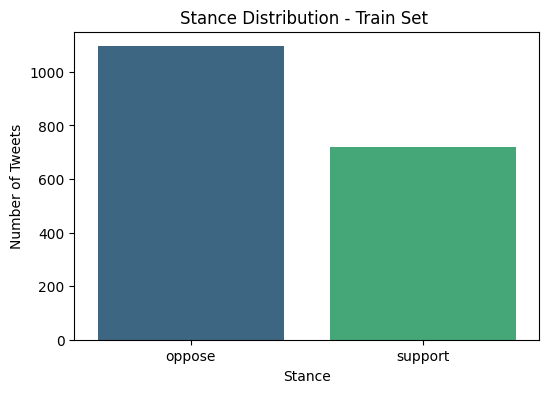

In [3]:
print("Train class distribution:")
stance_counts = df_train['stance'].value_counts()
print("Stance value counts:\n", stance_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=stance_counts.index, y=stance_counts.values, palette="viridis")
plt.title("Stance Distribution - Train Set ")
plt.ylabel("Number of Tweets")
plt.xlabel("Stance")
plt.show()

### Synonym Replacement (WordNet)

This technique randomly selects words in a sentence (excluding stop words) and replaces them with synonyms obtained from a lexical database like WordNet. The goal is to create semantically similar sentences without changing the meaning.  

**Example:**  
Original: "Gun control laws should be stricter to reduce crime."  
Augmented: "Firearm regulation rules should be tougher to reduce crime."


In [4]:
def augment_synonym_df(df, text_col="tweet_text", n=1, aug_p=0.2):
    aug = naw.SynonymAug(aug_p=aug_p)
    augmented_rows = []

    for _, row in df.iterrows():
        for _ in range(n):
            new_row = row.copy()

            aug_text = aug.augment(row[text_col])
            if isinstance(aug_text, list):
                aug_text = " ".join(aug_text)

            new_row[text_col] = aug_text
            augmented_rows.append(new_row)

    return pd.DataFrame(augmented_rows)


In [5]:
#To ensure reproducibility
random.seed(42)

minority_df = df_train[df_train["label"] == 1]
n_samples = (len(df_train[df_train["label"] == 0]) - len(minority_df))
rows_selected = minority_df.sample(n=n_samples, replace=True, random_state=42)
augmented_df = augment_synonym_df(rows_selected,text_col="tweet_text",n=1)
df_aug = pd.concat([df_train, augmented_df],ignore_index=True)
df_aug.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


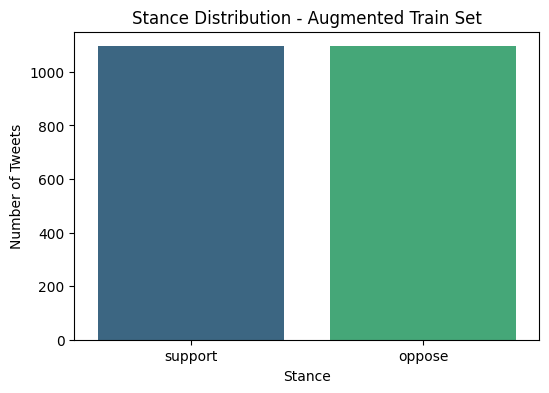

In [6]:
#Check new class distribution
stance_counts = df_aug['stance'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=stance_counts.index, y=stance_counts.values, palette="viridis")
plt.title("Stance Distribution - Augmented Train Set")
plt.ylabel("Number of Tweets")
plt.xlabel("Stance")
plt.show()

In [7]:
#Next steps is to generate the augmented images

# Pipeline for image augmentation (Very Safe, nothing too agressive)

transform = A.Compose([
    # Brightness and Contrast
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    # Color, Saturation and Hue adjustments
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),

    #Light Gaussian Blur
    A.GaussianBlur(blur_limit=1, p=0.1),

    #Light Noise
    A.GaussNoise(var_limit=(5.0, 10.0), p=0.1),

    #Light Cropping
    A.PadIfNeeded(min_height=224, min_width=224, p=1.0),    
    
    A.Resize(224, 224)
])

# We extract only the newly augmented rows
df_aux = df_aug.merge(df_train,on=df_train.columns.tolist(),how='left',indicator=True)
df_aux = df_aux[df_aux['_merge'] == 'left_only'].drop(columns=['_merge'])
df_aux.shape

(376, 8)

In [8]:
img_paths = []
for idx, row in df_aux.iterrows():
    tweet_id = row['tweet_id']
    print("tweet_id:", tweet_id)
    original_img_path = os.path.join(IMG_PATH, f"{tweet_id}.jpg")
    
    # We read the original image
    image = cv2.imread(original_img_path)

    if image is None:
        print(f"Image not found or cannot be opened: {original_img_path}")
        continue

    # Aplicar augmentations
    augmented = transform(image=image)['image']

    # Guardar imagen augmentada
    aug_name = f"{tweet_id}_aug.jpg"
    aug_path = os.path.join(IMG_PATH, aug_name)
    cv2.imwrite(aug_path, augmented)
    print(f"Augmented image {tweet_id} saved to {aug_path}")
    

tweet_id: 1262414988557385731
Augmented image 1262414988557385731 saved to ../../../data/images/1262414988557385731_aug.jpg
tweet_id: 1366814650155868165
Augmented image 1366814650155868165 saved to ../../../data/images/1366814650155868165_aug.jpg
tweet_id: 1340783552041005056
Augmented image 1340783552041005056 saved to ../../../data/images/1340783552041005056_aug.jpg
tweet_id: 1220039080668540928
Augmented image 1220039080668540928 saved to ../../../data/images/1220039080668540928_aug.jpg
tweet_id: 1351584272730124288
Augmented image 1351584272730124288 saved to ../../../data/images/1351584272730124288_aug.jpg
tweet_id: 1338659411175280640
Augmented image 1338659411175280640 saved to ../../../data/images/1338659411175280640_aug.jpg
tweet_id: 1103165762515189760
Augmented image 1103165762515189760 saved to ../../../data/images/1103165762515189760_aug.jpg
tweet_id: 1373119570584743938
Augmented image 1373119570584743938 saved to ../../../data/images/1373119570584743938_aug.jpg
tweet_id

In [9]:
aug_id_map = {row['tweet_id']: f"{row['tweet_id']}_aug" for _, row in df_aux.iterrows()}
df_aug['tweet_id'] = df_aug['tweet_id'].apply(lambda x: aug_id_map.get(x, x))
df_aug.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794_aug,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


In [10]:
#We Export the dataset
output_file = DATA_PATH+"train_augmented.csv"
df_aug.to_csv(output_file, index=False)
print(f"\nSummary results saved to: {output_file}")


Summary results saved to: ../../../data/train_augmented.csv


### Performance Experiment

In [11]:
# WE define our Models to tests and the seeds
MODELS = ["microsoft/deberta-v3-base"]

#Seeds
SEEDS = [42, 123, 456]


print("\nModels to test:")
for i, model in enumerate(MODELS, 1):
    print(f"  {i}. {model}")



Models to test:
  1. microsoft/deberta-v3-base


In [12]:
#Load Data

#Paths
OUTPUT_DIR = "../experiments/multimodal/data_augmentation/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

dev_path   = os.path.join(DATA_PATH,"dev.csv")
test_path  = os.path.join(DATA_PATH,"test.csv")

#Load Data
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_aug['label']==0).sum()}\n Support: {(df_aug['label']==1).sum()}")
df_aug.head()


dataset_train = Dataset.from_pandas(df_aug[["tweet_text", "label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text", "label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text", "label"]])



 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 1095


In [13]:

# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=105):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    tokenized = dataset.map(tokenize_batch, batched=True)

    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized


In [14]:
# We define metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary", pos_label=1)
    precision = precision_score(labels, preds, average="binary", pos_label=1)
    recall = recall_score(labels, preds, average="binary", pos_label=1)
    
    return {"accuracy": acc,"f1": f1,"precision": precision,"recall": recall}

In [15]:
# Training Function
def train_and_evaluate(model_name, seed, train_dataset, dev_dataset,test_dataset):

    # Set seed!
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    print(f"Training: {model_name} | Seed: {seed}")
    print(f"{'='*60}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Tokenizer loaded for {model_name}...")

    # Tokenize datasets with model tokenizer
    train_dataset_tok = tokenize_dataset(train_dataset, tokenizer, 105)
    dev_dataset_tok = tokenize_dataset(dev_dataset, tokenizer, 105)
    test_dataset_tok = tokenize_dataset(test_dataset, tokenizer, 105)
    print(f"Tokenization complete")


    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    print(f"Model Loaded: {model_name}.")


    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./temp_models/{model_name.replace('/', '_')}_seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        logging_steps=10
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tok,
        eval_dataset=dev_dataset_tok,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Train
    print(f"\n Starting training...")
    trainer.train()

    # Predictions on TEST set
    print(f"\n Getting predictions on TEST set...")
    predictions_output = trainer.predict(test_dataset_tok)
    y_pred = np.argmax(predictions_output.predictions, axis=1)
    y_true = predictions_output.label_ids



    # Evaluate
    print(f"\n Evaluating on test set...")
    eval_results = trainer.evaluate(test_dataset_tok)

    # Extract metrics
    results = {
        "model": model_name,
        "seed": seed,
        "accuracy": eval_results["eval_accuracy"],
        "precision": eval_results["eval_precision"],
        "recall": eval_results["eval_recall"],
        "f1": eval_results["eval_f1"],
        "loss": eval_results["eval_loss"],
        "y_true": y_true,
        "y_pred": y_pred
    }

    print(f"\n Results for {model_name} (seed {seed}):")
    print(f"   Accuracy:  {results['accuracy']:.4f}")
    print(f"   Precision: {results['precision']:.4f}")
    print(f"   Recall:    {results['recall']:.4f}")
    print(f"   F1-Score:  {results['f1']:.4f}")

    # Clean up to save memory
    del model
    del trainer
    del train_dataset_tok
    del dev_dataset_tok
    del test_dataset_tok

    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results

In [16]:
# We run the Experiments
print("STARTING EXPERIMENT")
print("="*60)

all_results = []
total_experiments = len(MODELS) * len(SEEDS)
current_experiment = 0

for model_name in MODELS:
    print(f"# MODEL: {model_name}")

    for seed in SEEDS:
        current_experiment += 1
        print(f"\n[Experiment {current_experiment}/{total_experiments}]")
        results = train_and_evaluate(
            model_name=model_name,
            seed=seed,
            train_dataset=dataset_train,
            dev_dataset=dataset_dev,
            test_dataset=dataset_test)


        all_results.append(results)


print("EXPERIMENT COMPLETED")

STARTING EXPERIMENT
# MODEL: microsoft/deberta-v3-base

[Experiment 1/3]
Training: microsoft/deberta-v3-base | Seed: 42
Tokenizer loaded for microsoft/deberta-v3-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded: microsoft/deberta-v3-base.


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.474400,0.301454,0.900000,0.846154,0.964912,0.753425
2,0.215800,0.340178,0.880000,0.818182,0.915254,0.739726
3,0.094200,0.410046,0.900000,0.846154,0.964912,0.753425
4,0.053100,0.377020,0.920000,0.887324,0.913043,0.863014
5,0.031500,0.472794,0.905000,0.861314,0.921875,0.808219



 Getting predictions on TEST set...



 Evaluating on test set...



 Results for microsoft/deberta-v3-base (seed 42):
   Accuracy:  0.8433
   Precision: 0.7415
   Recall:    0.9237
   F1-Score:  0.8226

[Experiment 2/3]
Training: microsoft/deberta-v3-base | Seed: 123
Tokenizer loaded for microsoft/deberta-v3-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Model Loaded: microsoft/deberta-v3-base.

 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.478400,0.323265,0.850000,0.782609,0.830769,0.739726
2,0.237500,0.346475,0.885000,0.824427,0.931034,0.739726
3,0.145500,0.360921,0.915000,0.877698,0.924242,0.835616
4,0.082700,0.439104,0.905000,0.859259,0.935484,0.794521
5,0.038000,0.484529,0.910000,0.869565,0.923077,0.821918



 Getting predictions on TEST set...



 Evaluating on test set...



 Results for microsoft/deberta-v3-base (seed 123):
   Accuracy:  0.8533
   Precision: 0.7721
   Recall:    0.8898
   F1-Score:  0.8268

[Experiment 3/3]
Training: microsoft/deberta-v3-base | Seed: 456
Tokenizer loaded for microsoft/deberta-v3-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Model Loaded: microsoft/deberta-v3-base.

 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.496400,0.349422,0.900000,0.843750,0.981818,0.739726
2,0.249800,0.302629,0.905000,0.854962,0.965517,0.767123
3,0.138500,0.331836,0.895000,0.848921,0.893939,0.808219
4,0.066700,0.414013,0.915000,0.875912,0.937500,0.821918
5,0.033600,0.455983,0.905000,0.863309,0.909091,0.821918



 Getting predictions on TEST set...



 Evaluating on test set...



 Results for microsoft/deberta-v3-base (seed 456):
   Accuracy:  0.8467
   Precision: 0.7466
   Recall:    0.9237
   F1-Score:  0.8258
EXPERIMENT COMPLETED


In [17]:
# Results
results_df = pd.DataFrame(all_results)

# Per model we calculate the mean and std on each metric
model_stats = results_df.groupby('model').agg({
    'accuracy': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'f1': ['mean', 'std']
}).round(4)

# Format
model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns.values]
model_stats = model_stats.reset_index()
model_stats.columns = [
    'Model',
    'Accuracy_Mean', 'Accuracy_Std',
    'Precision_Mean', 'Precision_Std',
    'Recall_Mean', 'Recall_Std',
    'F1_Mean', 'F1_Std'
]

# Sort by F1 score
model_stats = model_stats.sort_values('F1_Mean', ascending=False).reset_index(drop=True)
print(model_stats)

                       Model  Accuracy_Mean  Accuracy_Std  Precision_Mean  \
0  microsoft/deberta-v3-base         0.8478        0.0051          0.7534   

   Precision_Std  Recall_Mean  Recall_Std  F1_Mean  F1_Std  
0         0.0164       0.9124      0.0196   0.8251  0.0022  


In [18]:
# Results to CSV
output_file = "augmented_results.csv"
model_stats.to_csv(output_file, index=False)
print(f"\nSummary results saved to: {output_file}")


Summary results saved to: augmented_results.csv
